<a href="https://colab.research.google.com/github/Baldros/Prithvi_WxC-ModelExemples-/blob/main/PrithviWxC(Downscaled).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação:

O objetivo desse código é estudar como usar um modelo de _downscaling_ ajustado para gerar inferências. Mostramos como inicializar o modelo, carregar os pesos e usar o modelo para inferência.

A construção e utilização do modelo aqui segue uma construção um pouco diferente, mas em é a mesma coisa, mudando obviamente a tarefa. O jeito de baixar as coisas pode parecer um pouco diferente, mas a estruturação é em essência a mesma.

**Caso precise configurar um ambiente virtual, _env_ específica para esse estudo, estes comandos podem ajudar. Mas só funcionam se você utiliza o ambiente anaconda.**


- `conda create -n prithviwxc python=3.11`
- `conda activate prithviwxc`
- `pip install h5netcdf matplotlib wget pyyaml xarray scipy torch`
- `pip install -e <path to cloned PrithviWxC repo>` (see https://github.com/NASA-IMPACT/Prithvi-WxC)
- `pip install -e <path to cloned granite-wxc repo>` (see https://github.com/IBM/granite-wxc/)

In [1]:
import sys
if 'google.colab' in sys.modules:
  !pip install h5netcdf matplotlib wget pyyaml xarray scipy torch granitewxc
  !git clone https://github.com/NASA-IMPACT/Prithvi-WxC.git
  !sed -i 's/>=3\.11/>=3\.10/g' ./Prithvi-WxC/pyproject.toml
  !sed -i 's/pandas ~= 2\.2/pandas/g' ./Prithvi-WxC/pyproject.toml
  !pip install ./Prithvi-WxC
  !git clone https://github.com/IBM/granite-wxc.git
  !sed -i 's/>=3\.11/>=3\.10/g' ./granite-wxc/pyproject.toml
  !sed -i 's/scipy >= 1\.14\.1/scipy/g' ./granite-wxc/pyproject.toml
  !pip install ./granite-wxc

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement granitewxc (from versions: none)
ERROR: No matching distribution found for granitewxc
Cloning into 'Prithvi-WxC'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 229 (delta 37), reused 26 (delta 13), pack-reused 151 (from 1)
Receiving objects: 100% (229/229), 426.13 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Processing ./Prithvi-WxC
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PrithviWxC: filename=prithviwxc-0.1.0-py3-none-any.whl size=26373 sha256=b8555756f15941a846530e851c51310a11300d7a5b774b8bf494cdeaf4ac9a4f
  Stored in directory: /root/.cache/pip/wheels/ba/a9/de/2c8f877ea6c40bd6fc29a7d2a19ff0988948fa6c6ee04027af
Successfully built PrithviWxC
Cloning

In [2]:
# Bibliotecas utilizadas:
import os
import wget
import random
from pathlib import Path

import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import torch
from torch.utils.data import DataLoader

from granitewxc.utils.config import get_config
from granitewxc.utils.data import _get_transforms
from granitewxc.datasets.merra2 import Merra2DownscaleDataset
from granitewxc.utils.downscaling_model import get_finetune_model
from PrithviWxC.dataloaders.merra2 import SampleSpec
from granitewxc.utils.plot import *

Configure os back-ends e os estados da tocha, incluindo a definição das sementes para os RNGs

In [3]:
# Habilitanto onednn Fusion:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Avaliando tipo de device:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Configuração de Carregamento:

Fornecemos um arquivo de configuração que é usado para configurar as variáveis de dados e os parâmetros do modelo. Para a inferência, a maioria dessas configurações é usada como está. Isso inclui as variáveis com as quais o modelo foi treinado, as variáveis que realizamos o downscaling, o número de passos de tempo de entrada, o nível de downscaling, e as dimensões do embedding do modelo. Quando necessário, mostraremos quais configurações precisam ser especificadas ou alteradas fora do que já está definido neste arquivo.








In [5]:
# Baixando arquivo yaml:
wget.download('https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling/resolve/main/config.yaml')
config_path = './config.yaml'
config = get_config(config_path)

#  Download do modelo e das amostras de dados:

Fornecemos dados de exemplo do conjunto de dados MERRA-2 para um único dia (01 de janeiro de 2020) e [pesos](https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling/tree/main) para um modelo de downscaling ajustado que utilizamos neste notebook. Estes serão baixados quando você executar as células abaixo.

Before running the download set `config.download_path` to the directory where you want the model and sample data to be downloaded

*Note*: With `config.download_path = './'` the files are downloaded in the current working directory

In [6]:
config.download_path = './'

In [7]:
wget.download('https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling/resolve/main/pytorch_model.bin', out=config.download_path)
os.makedirs(os.path.join(config.download_path, 'climatology'), exist_ok=True)
os.makedirs(os.path.join(config.download_path, 'merra-2'), exist_ok=True)
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/merra-2/MERRA2_sfc_20200101.nc', out=os.path.join(config.download_path, 'merra-2', 'MERRA2_sfc_20200101.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/merra-2/MERRA_pres_20200101.nc', out=os.path.join(config.download_path, 'merra-2', 'MERRA_pres_20200101.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/anomaly_variance_surface.nc', out=os.path.join(config.download_path, 'climatology', 'anomaly_variance_surface.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/anomaly_variance_vertical.nc', out=os.path.join(config.download_path, 'climatology', 'anomaly_variance_vertical.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/musigma_surface.nc', out=os.path.join(config.download_path, 'climatology', 'musigma_surface.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/musigma_vertical.nc', out=os.path.join(config.download_path, 'climatology', 'musigma_vertical.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour00.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour00.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour03.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour03.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour06.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour06.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour09.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour09.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour12.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour12.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour15.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour15.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour18.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour18.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_surface_doy001_hour21.nc', out=os.path.join(config.download_path, 'climatology', 'climate_surface_doy001_hour21.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour00.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour00.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour03.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour03.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour06.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour06.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour09.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour09.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour12.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour12.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour15.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour15.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour18.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour18.nc'))
wget.download('https://huggingface.co/Prithvi-WxC/prithvi.wxc.2300m.v1/resolve/main/climatology/climate_vertical_doy001_hour21.nc', out=os.path.join(config.download_path, 'climatology', 'climate_vertical_doy001_hour21.nc'))

'./climatology/climate_vertical_doy001_hour21.nc'

Based on the path to the sample data downloaded in the above cells we specify the paths that are required by the dataloaders

In [8]:
config.data.data_path_surface = os.path.join(config.download_path,'merra-2')
config.data.data_path_vertical = os.path.join(config.download_path, 'merra-2')
config.data.climatology_path_surface = os.path.join(config.download_path,'climatology')
config.data.climatology_path_vertical = os.path.join(config.download_path,'climatology')

config.model.input_scalers_surface_path = os.path.join(config.download_path,'climatology/musigma_surface.nc')
config.model.input_scalers_vertical_path = os.path.join(config.download_path,'climatology/musigma_vertical.nc')
config.model.output_scalers_surface_path = os.path.join(config.download_path,'climatology/anomaly_variance_surface.nc')
config.model.output_scalers_vertical_path = os.path.join(config.download_path,'climatology/anomaly_variance_vertical.nc')

# Dataloader

Com o ambiente pronto, agora precisamos configurar a tarefa. O modelo principal espera um conjunto fixo de variáveis do conjunto de dados MERRA-2, que são definidas no arquivo de configuração. As variáveis são compostas por variáveis de superfície, variáveis estáticas de superfície, e variáveis em vários níveis verticais dentro da atmosfera. Mais detalhes sobre o conjunto de dados MERRA-2 podem ser encontrados [aqui](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/).

A tarefa do modelo é, dado os dados de entrada, aumentar a resolução da temperatura de superfície a 2 metros em 6 vezes.

In [9]:
# Range temporal:
config.data.val_time_range_start = '2020-01-01T00:00:00'
config.data.val_time_range_end = '2020-01-01T23:59:59'

Inicializar a classe `Merra2DownscaleDataset`.

Essa classe é usada para criar amostras conforme esperado pelo modelo de downscaling. Utilizando as transformações especificadas na classe do dataset, tornamos os dados **MERRA-2** mais grosseiros e suavizados para usá-los como entrada de baixa resolução no nosso modelo. Os dados originais são usados como dados de alta resolução correspondentes.

In [10]:
# Instanciando Dataset:
dataset = Merra2DownscaleDataset(
    time_range=(config.data.val_time_range_start, config.data.val_time_range_end),
    data_path_surface = config.data.data_path_surface,
    data_path_vertical = config.data.data_path_vertical,
    climatology_path_surface = config.data.climatology_path_surface,
    climatology_path_vertical = config.data.climatology_path_vertical,
    input_surface_vars = config.data.input_surface_vars,
    input_static_surface_vars = config.data.input_static_surface_vars,
    input_vertical_vars = config.data.input_vertical_vars,
    input_levels = config.data.input_levels,
    n_input_timestamps = config.data.n_input_timestamps,
    output_vars=config.data.output_vars,
    transforms=_get_transforms(config),
)

assert len(dataset) > 0, "Não parece haver nenhum dado válido."

In [11]:
dataloader = DataLoader(dataset, batch_size=1)

# Inicialização do Modelo

Construímos o modelo usando a configuração carregada. Para usar o modelo para inferência com os pesos fornecidos, manteremos a configuração do modelo igual à definida no arquivo de configuração.

O modelo de **_downscaling graintewxc_** consiste em uma camada de patch _embedding_, seguida por uma camada de _upscaling_ que aumenta a resolução em 2 vezes. Em seguida, utilizamos o codificador pré-treinado do modelo **PrithviWxC**, seguido de outra operação de _upscaling_ que aumenta a resolução em 3 vezes, resultando em um ganho total de resolução de 6 vezes.

In [12]:
# Instanciando modelo:
model = get_finetune_model(config, logger=None)
model

Creating the model.
Encoder shifting: False


ClimateDownscaleFinetuneModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-24): 25 x Transformer(
          (drop_path): DropPath()
          (attention): Sequential(
            (0): LayerNormPassThrough((2560,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=2560, out_features=7680, bias=False)
              (w_layer): Linear(in_features=2560, out_features=2560, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=2560, out_features=10240, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=10240, out_features=2560, bias=True)
                (4): Dropout(p=0.0, 

# Carregando Pesos

Agora podemos carregar os pesos que baixamos anteriormente no modelo que inicializamos.

In [13]:
# Carregando Pesos:
weights_path = Path(config.download_path,'pytorch_model.bin')
model.load_state_dict(torch.load(weights_path, weights_only=False, map_location=device))
model.to(device)

ClimateDownscaleFinetuneModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-24): 25 x Transformer(
          (drop_path): DropPath()
          (attention): Sequential(
            (0): LayerNormPassThrough((2560,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=2560, out_features=7680, bias=False)
              (w_layer): Linear(in_features=2560, out_features=2560, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=2560, out_features=10240, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=10240, out_features=2560, bias=True)
                (4): Dropout(p=0.0, 

# Inferência:

O modelo está agora pronto para a inferência. Estamos executando a inferência para apenas uma amostra, mas você pode adicionar um loop para executar a inferência para múltiplas amostras.

In [14]:
import torch
with torch.no_grad():
    model.eval()

    batch = next(iter(dataloader))
    batch = {k: v.to(device) for k, v in batch.items()}
    out = model(batch)

    inputs = batch['x']
    targets = batch['y']
    outputs = out

In [15]:
inputs.shape, targets.shape, outputs.shape

(torch.Size([1, 280, 60, 96]),
 torch.Size([1, 1, 360, 576]),
 torch.Size([1, 1, 360, 576]))

# Visualizando Resultado:

Pós instaciamento do modelo e do conjunto de dados, podemos simplesmente realizar o feedfoward para visualizar o resultado da inferência do modelo dado um conjunto de dados de entrada de baixa resolução espacial.

In [16]:
var_name = "T2M"
var_name_title = '2M air temperature'
var_unit = "K"

input_vars = [*config.data.input_surface_vars, *product(config.data.input_vertical_vars, config.data.input_levels)]
input_t2m_index= input_vars.index(var_name)

sample_idx = 0
coarsening_factor = targets.shape[-1] / inputs.shape[-1]
sample_timestamp, sample_it, sample_lt = dataset.dataset.samples[sample_idx][0]
sample_time_spec = SampleSpec.get(sample_timestamp, -sample_it, sample_lt)
sample_time = sample_time_spec.inputs[-1]

f'{var_name_title} at {sample_time} is downscaled by {coarsening_factor}x'

'2M air temperature at 2020-01-01 03:00:00 is downscaled by 6.0x'

In [17]:
plot_input = inputs[0, input_t2m_index, :, :].detach().cpu().numpy()
plot_target = targets[0, 0, : ,:].detach().cpu().numpy()
plot_output = outputs[0, 0, :, :].detach().cpu().numpy()
plot_residual = plot_target - plot_output

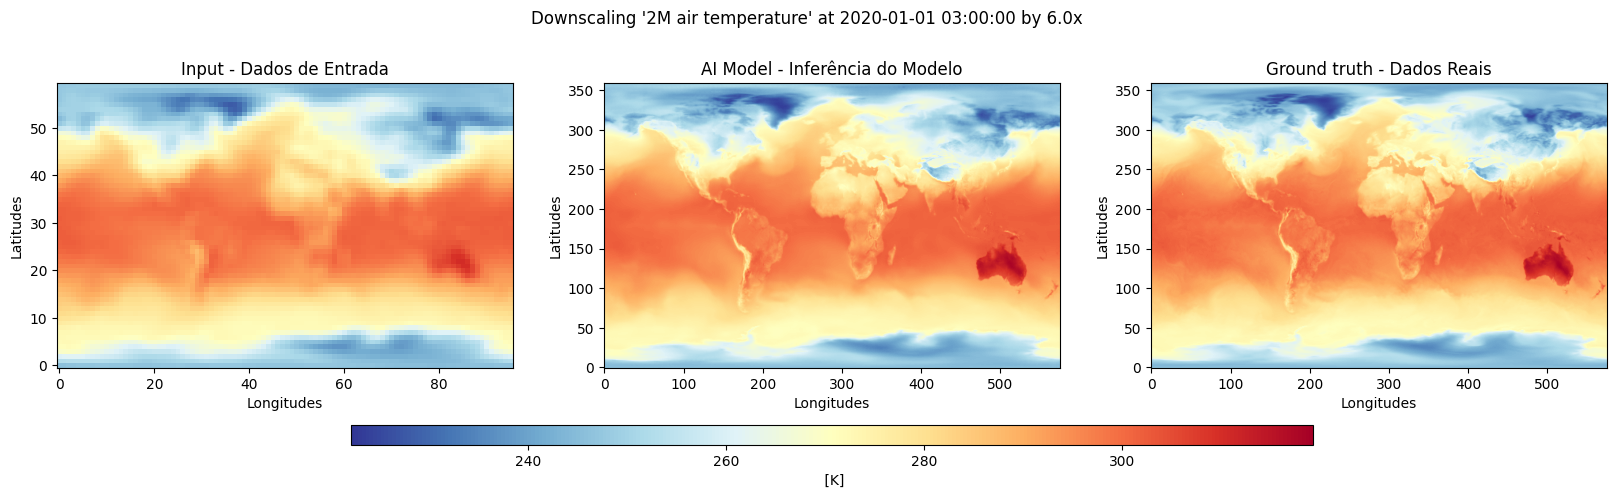

In [18]:
plot_val_kwargs = dict(
    cmap='RdYlBu_r',
    vmin = min(np.min(plot_input), np.min(plot_target), np.min(plot_output)),
    vmax = max(np.max(plot_input), np.max(plot_target), np.max(plot_output)),
    plot_residual_kwargs = dict(
        cmap = 'bwr',
        vmin = -np.max(np.abs(plot_residual)),
        vamx = np.max(np.abs(plot_residual)),
    ),
    var_name_title=var_name_title,
    var_unit=var_unit
)

plot_model_results(
    [plot_input, plot_output, plot_target],
    ['Input - Dados de Entrada', 'AI Model - Inferência do Modelo', 'Ground truth - Dados Reais'],
    title=f"Downscaling '{var_name_title}' at {sample_time} by {coarsening_factor}x",
    **plot_val_kwargs
)

Text(0.5, 1.0, 'Power spectrum of 2M air temperature')

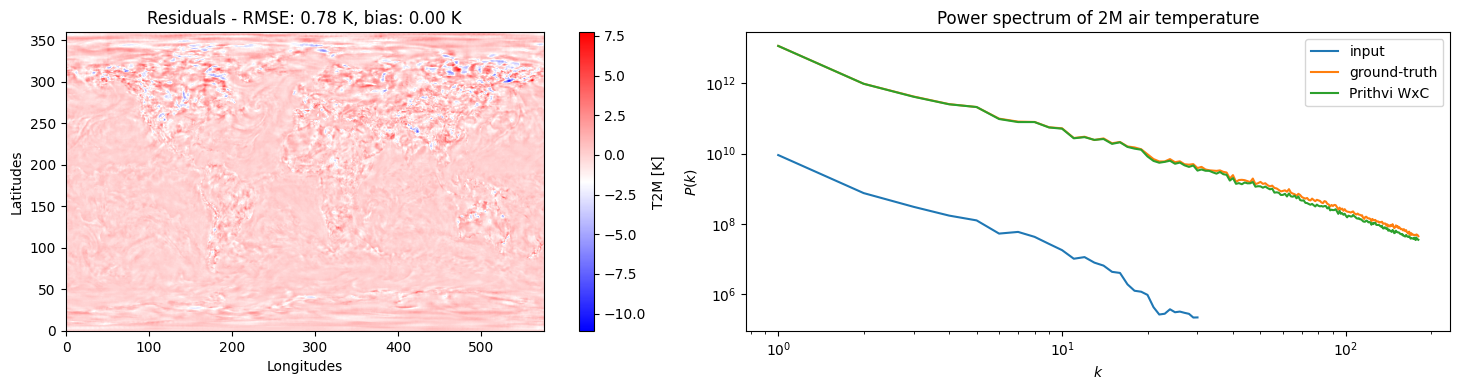

In [19]:
vmin_res = -np.max(np.abs(plot_residual))
vmax_res = np.max(np.abs(plot_residual))
pred_bias = spatial_bias(plot_output, plot_target)
pred_rmse = spatial_rmse(plot_output, plot_target)

fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(15,4))

title = 'Residuals - RMSE: {:.2f} K, bias: {:.2f} K'.format(pred_rmse, pred_bias)
im_res = plot_spatial(plot_residual, axs[0], title,  **plot_val_kwargs.get('plot_residual_kwargs'))
cbar = plt.colorbar(im_res, ax=axs[0], orientation='vertical', label=f'{var_name} [K]')

plot_power_spectrum(plot_input, axs[1])
plot_power_spectrum(plot_target, axs[1])
plot_power_spectrum(plot_output, axs[1])
axs[1].legend(['input', 'ground-truth', 'Prithvi WxC'])
axs[1].set_title(f'Power spectrum of {var_name_title}')